In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc

In [2]:
path = r"C:/Users/danie/Documents/Projects/fraud_detection/"
ftrain = pd.read_csv(path+'fraud_train.csv')
ftest = pd.read_csv(path+'fraud_test.csv')
# convert the index unnamed column into a unique identifier
ftrain.rename(columns = {'Unnamed: 0': 'id'}, inplace=True)
ftest.rename(columns = {'Unnamed: 0': 'id'}, inplace=True)
# convert the test id to make it consistent, starting from max(id)+1 in train
ftest['id']+=np.max(ftrain['id'])+1

In [3]:
ftrain.columns

Index(['id', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [4]:
print(ftrain.shape, ftest.shape)

(1296675, 23) (555719, 23)


In [5]:
ftrain.shape[0]+ftest.shape[0]

1852394

### 0. Real-world problem simulation
Combine the train and test dataset. Total about 185k transaction activities (129k in training dataset;; 55k in test dataset). <br>
First, combine all activities. How to simulate real-world condition: <br>
1. Suppose we only know the first 1.5 years' activity data (01/01/2019 - 06/30/2020)
2. Use the last half year as test dataset (around 29%-30% of the dataset)
3. In supervised models, use k-fold cross validation
Unsupervised (df): user profiling, merchant profiling <br>
Supervised (df): transaction activity

In [6]:
ftrain['trans_date_trans_time'] = pd.to_datetime(ftrain['trans_date_trans_time'])
ftest['trans_date_trans_time'] = pd.to_datetime(ftest['trans_date_trans_time'])
df = pd.concat([ftrain, ftest])

In [7]:
print(ftrain.shape[0], ftest.shape[0], df.shape[0])
print(ftrain.shape[0] / df.shape[0])

1296675 555719 1852394
0.6999995681264353


In [8]:
df1 = df[df['trans_date_trans_time']<='06/30/2020'].copy()
df2 = df[df['trans_date_trans_time']>='07/01/2020'].copy()

In [9]:
print(df1.shape[0], df2.shape[0])
print(df1.shape[0] / df.shape[0])

1322861 525661
0.7141358695828209


In [161]:
print(df1[df1['is_fraud']==1].shape[0], df1[df1['is_fraud']==0].shape[0])
print(df1[df1['is_fraud']==1].shape[0]/df1.shape[0])

7601 1315260
0.005745879574649188


### 1. transaction activities

### 1.1 Transaction Pattern
#### 1.1.1 Transaction amount pattern <br>
Divide the transaction amount into four segments for each credit card: extreme, high, medium and low.

-------
For transactions of each credit card:
1. Apply 68-95-99 rule, flag transactions having amount > mean + 3 SD as "extreme"
2. Use 1-d clustering the rest transactions into group: high, medium and low
------


In [36]:
def trans_amt_pattern(df, cc_col): 
    # obtain the list of unique cards, identified by unique credit card number
    cards, df_labeled = list(np.unique(df[cc_col])), pd.DataFrame()
    for cc in cards: 
        # obtain transactions of one card number
        df_temp = df[df[cc_col]==cc].copy()
        # obtain the boundary for outlier (mean+3 SD)
        boundary = np.mean(df[df[cc_col]==cc]['amt']) + 3 * np.std(df[df[cc_col]==cc]['amt'])
        # split the data to temporary tables: extreme value and non-extreme value
        temp_ext, temp_nonext = df_temp[df_temp['amt']>boundary], df_temp[df_temp['amt']<=boundary]
        # run k-means clustering to divide non-extreme value into three groups
        kmeans = KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=40)
        kmeans.fit(np.array(temp_nonext['amt']).reshape(-1, 1))
        # assgin labels to the temporary tables
        temp_ext, temp_nonext = temp_ext.copy(), temp_nonext.copy()
        temp_ext['label'] = [3]*temp_ext.shape[0]
        temp_nonext['label'] = kmeans.labels_
        # kmeans labels no associated with numerical values, need to re-assign numerical labels
        # sort the label (0-2) in ascending order of average
        avg_list = [np.mean(temp_nonext[temp_nonext['label']==i]['amt']) for i in range(max(kmeans.labels_)+1)]
        sorted_label = np.argsort(avg_list)
        # convert the labels to "low", "medium", and "high" based on mean, then assign 0, 1, 2 to them respectively
        temp_dict1 = {sorted_label[0]: 'low', sorted_label[1]: 'medium', sorted_label[2]: 'high'}
        temp_dict2 = {'low': 0, 'medium': 1, 'high': 2}
        for key, value in temp_dict1.items():
            temp_nonext.loc[temp_nonext.label == key, 'label'] = value
        for key, value in temp_dict2.items(): 
            temp_nonext.loc[temp_nonext.label == key, 'label'] = value
        # all results for this card number
        temp_all = pd.concat([temp_ext, temp_nonext])
        # iteratively get all labeled result to a new dataframe
        df_labeled = pd.concat([df_labeled, temp_all])
    return df_labeled

In [37]:
df1_labeled = trans_amt_pattern(df1, 'cc_num')

In [38]:
df2_labeled = trans_amt_pattern(df2, 'cc_num')

In [30]:
df1_labeled.shape

(1322861, 24)

In [39]:
df2_labeled.shape

(525661, 24)

In [32]:
# temporarily save the progress
df1_labeled.to_csv(path+r'f1_ver1.0.xlsx')

In [40]:
df2_labeled.to_csv(path+r'f2_ver1.0.xlsx')

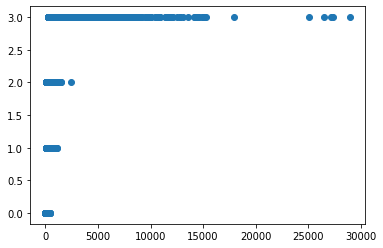

In [35]:
plt.scatter(df1_labeled['amt'], df1_labeled['label'])

#### 1.1.2 Transaction location pattern <br>
Use the location information of the customer and merchant to categorize the transaction into three types: 0 - local (same city), 1 - national (same country but not same city), 2 - international (different country)


In [52]:
df1.reset_index(inplace=True, drop=True)
df1_labeled.reset_index(inplace=True, drop=True)
df2.reset_index(inplace=True, drop=True)
df2_labeled.reset_index(inplace=True, drop=True)

In [83]:
def getCityCountry(lat, long): 
    geolocator = Nominatim(user_agent="geoapiExercises")
    location = geolocator.reverse(str(lat)+","+str(long))
    address = location.raw['address']
    return address.get('county', ''), address.get('city', ''), address.get('country', '')

In [144]:
def getLocInfo(df, clat, clong, mlat, mlong): 
    # obtain coordinates in tuple from latitude and longitude
    c_coords = df[[clat, clong]].apply(tuple, axis=1).tolist()
    m_coords = df[[mlat, mlong]].apply(tuple, axis=1).tolist()
    # obtain district and country information
    c_res = rg.search(c_coords)
    df['c_district'] = [item['name'] for item in c_res]
    df['c_country'] = [item['cc'] for item in c_res]
    m_res = rg.search(m_coords)
    df['m_district'] = [item['name'] for item in m_res]
    df['m_country'] = [item['cc'] for item in m_res]
    # generqte conditions
    conditions = [
        (df['c_district']==df['m_district']),
        (df['c_district']!=df['m_district']) & (df['c_country']==df['m_country']),
        (df['c_country']!=df['m_country']),
        ]
    # 0 - same district; 1 - same country; 2 - international
    values = [0, 1, 2]
    df['addr_label'] = np.select(conditions, values)
    return df

In [148]:
df1_lv2 = getLocInfo(df1_labeled, 'lat', 'long', 'merch_lat', 'merch_long')

In [156]:
df2_lv2 = getLocInfo(df2_labeled, 'lat', 'long', 'merch_lat', 'merch_long')

#### 1.1.3 Transaction date & time information
Generate two columns from the transaction datetime. 

------
1. Day of the week: Sunday, Monday,.... <br>
   Class 0: Monday <br>
   ... <br>
   Class 6: Sunday
2. Time of the day: <br>
   Class 0: Morning, 6 am - 12 pm <br>
   Class 1: Afternoon, 12 pm - 6 pm <br>
   Class 2: Evening, 6 pm - 12 am <br>
   Class 3: Midnight, 12 am - 6 am 
-------


In [179]:
def getDayTime(df, dtcol): 
    df[dtcol] = pd.to_datetime(df[dtcol])
    df['weekday_label'] = df[dtcol].dt.weekday
    time_bins = [0, 6, 12, 18, 24]
    labels = [3, 0, 1, 2]
    df['time_label'] = pd.cut(df[dtcol].dt.hour, time_bins, labels=labels, right=False)
    return df

In [180]:
df1_lv3 = getDayTime(df1_lv2, 'trans_date_trans_time')

In [185]:
df2_lv3 = getDayTime(df2_lv2, 'trans_date_trans_time')

#### 1.1.4 Get Dummy Variables for categories
In terms of categories, label encoding is not sufficient. It is necessary to create dummy variables to provide better information to the model. 

In [228]:
# create dummy variables
df1_dummy = pd.get_dummies(df1_lv3['category'].copy())
# dummy variables should contain one less than total number of classes
df1_lv4 = pd.concat([df1_lv3, df1_dummy.iloc[:,1:]], axis=1)

In [229]:
print(df1_dummy.shape, df1_lv3.shape, df1_lv4.shape)

(1322861, 14) (1322861, 32) (1322861, 45)


In [232]:
df2_dummy = pd.get_dummies(df2_lv3['category'].copy())
df2_lv4 = pd.concat([df1_lv3, df1_dummy.iloc[:,1:]], axis=1)

### 2. Modeling
#### 2.1 Random Forest

In [297]:
c1 = df1_lv4[df1_lv4['cc_num']==df1_lv4['cc_num'][30000]]
print(c1.shape)

(3190, 45)


In [308]:
c1 = df1_lv4[df1_lv4['cc_num']==df1_lv4['cc_num'][0]]
c1.reset_index(inplace=True, drop=True)
dummy_cols = list(df1_dummy.columns)[1:]
cols = ['label', 'addr_label', 'weekday_label', 'time_label']+dummy_cols
X = df1_lv4[cols]
y = df1_lv4['is_fraud']

In [309]:
minrtomaj = y[y==1].shape[0] / y[y==0].shape[0]

In [310]:
X = X.copy()
X['time_label']=pd.to_numeric(X['time_label'])

In [317]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score = []
weights = {0:1, 1: 1/minrtomaj}
rf = RandomForestClassifier(n_estimators=10, class_weight = weights, random_state=10)
for t1, t2 in skf.split(X, y): 
    x_train, x_test = X.iloc[t1,:], X.iloc[t2,:]
    y_train, y_test =  y[t1], y[t2]
    rf.fit(x_train, y_train)
    rf_prob = rf.predict_proba(x_test)
    rf_probs = rf_prob[:, 1]
    yhat = rf.predict(x_test)
    rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
    rf_f1, rf_auc = f1_score(y_test, yhat), auc(rf_recall, rf_precision)
    print('Logistic: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
    score.append(rf_auc)

Logistic: f1=0.078 auc=0.356
Logistic: f1=0.080 auc=0.359
Logistic: f1=0.072 auc=0.369
Logistic: f1=0.071 auc=0.381
Logistic: f1=0.077 auc=0.356


Text(0, 0.5, 'Precision')

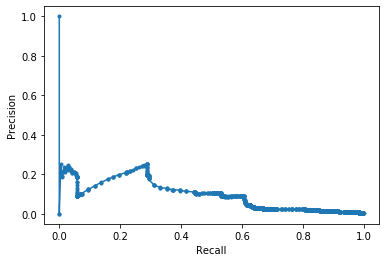

In [318]:
import matplotlib.pyplot as plt
#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

In [323]:
%matplotlib
subset1 = df1_labeled[df1_labeled['cc_num']==cards[0]]
plt.scatter(subset1['amt'], subset1['label'])
plt.xlabel('transaction amount')
plt.ylabel('amount label')
plt.title('Transaction Amount Label for Card #'+str(cards[0]))
plt.show()

Using matplotlib backend: Qt5Agg
